# Power Spectral Density

In [1]:
!pip install mne
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.5 MB/s eta 0:00:00


In [2]:
import zipfile
import os
from pyedflib import highlevel
import pandas as pd
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
# Downloading the dataset from Physionet
!wget -c https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip -O eeg.zip

--2024-07-05 20:56:33--  https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183634285 (175M) [application/zip]
Saving to: ‘eeg.zip’

eeg.zip             100%[===================>] 175.13M   471KB/s    in 6m 13s  

2024-07-05 21:02:46 (480 KB/s) - ‘eeg.zip’ saved [183634285/183634285]



In [4]:
# Extracting the ZIP file
with zipfile.ZipFile('eeg.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/eeg')

In [5]:
# Function to read EDF files and retrieve EEG signals, headers, and overall header
def load_eeg(file_path):
    signals, signal_headers, header = highlevel.read_edf(file_path)
    print("Signal headers:", signal_headers)  # To inspect the structure
    return signals, signal_headers, header

In [6]:
# Setting up frequency bands and defining a function to calculate PSD for each band
frequency_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

def calculate_bandwise_psd(signals, signal_headers):
    ch_names = [sh['label'] for sh in signal_headers]  # Collecting channel names
    sfreq = signal_headers[0]['sample_rate']           # Correct key for sample rate

    # Creating an MNE Info object and RawArray for PSD calculation
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(signals, info)

    psd_dict = {}
    for band, (fmin, fmax) in frequency_bands.items():
        # Using psd_array_welch directly on the numpy array
        psds, freqs = psd_array_welch(raw.get_data(), sfreq, fmin=fmin, fmax=fmax,
                                      n_fft=int(sfreq * 2), verbose=False)
        psd_dict[band] = np.mean(psds, axis=0)  # Average PSDs across channels
    return psd_dict

In [8]:
# Associating each EDF file to its respective cognitive state, 'rest' or 'task'
eeg_files = {}
data_dir = "/content/eeg/eeg-during-mental-arithmetic-tasks-1.0.0"
for filename in os.listdir(data_dir):
    if filename.endswith('.edf'):
        subject_id, state_code = filename.split('_')
        state = 'rest' if state_code.endswith('1.edf') else 'task'
        if subject_id not in eeg_files:
            eeg_files[subject_id] = {}
        eeg_files[subject_id][state] = os.path.join(data_dir, filename)

# Calculating band-wise Power Spectral Density (PSD) for both 'rest' and 'task' states
psd_results = []
for subject_id, files in eeg_files.items():
    results = {'Subject': subject_id}
    for state, filepath in files.items():
        signals, signal_headers, _ = load_eeg(filepath)
        psd_dict = calculate_bandwise_psd(signals, signal_headers)
        for band, psd_values in psd_dict.items():
            results[f'{band} {state} Mean PSD'] = np.mean(psd_values)
    psd_results.append(results)

Signal headers: [{'label': 'EEG Fp1', 'dimension': 'uV', 'sample_rate': 500.0, 'sample_frequency': 500.0, 'physical_max': 45.01735, 'physical_min': -45.2849, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': '', 'transducer': ''}, {'label': 'EEG Fp2', 'dimension': 'uV', 'sample_rate': 500.0, 'sample_frequency': 500.0, 'physical_max': 54.45004, 'physical_min': -59.2055, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': '', 'transducer': ''}, {'label': 'EEG F3', 'dimension': 'uV', 'sample_rate': 500.0, 'sample_frequency': 500.0, 'physical_max': 43.30572, 'physical_min': -42.7124, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': '', 'transducer': ''}, {'label': 'EEG F4', 'dimension': 'uV', 'sample_rate': 500.0, 'sample_frequency': 500.0, 'physical_max': 42.93491, 'physical_min': -43.6936, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': '', 'transducer': ''}, {'label': 'EEG F7', 'dimension': 'uV', 'sample_rate': 500.0, 'sample_frequency': 500.0, 'physical

In [9]:
results_df = pd.DataFrame(psd_results)
results_df = results_df.sort_values(by='Subject')

# Adding the label
subject_info = pd.read_csv("/content/eeg/eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv")
results_df = pd.merge(results_df, subject_info[['Subject', 'Count quality']], on='Subject', how='left')
results_df.to_csv('/content/psd_analysis_results.csv', index=False)

In [10]:
# Initializing an empty list to store summary results
summary_results = []

# Looping through each subject's results
for result in psd_results:
    subject_summary = {'Subject': result['Subject']}
    # Calculating differences and perform t-tests for each band
    for band in frequency_bands.keys():
        rest_key = f'{band} rest Mean PSD'
        task_key = f'{band} task Mean PSD'
        if rest_key in result and task_key in result:
            mean_difference = result[task_key] - result[rest_key]
            subject_summary[f'{band} Mean Difference'] = mean_difference
    summary_results.append(subject_summary)

# Converting summary results to DataFrame and output
summary_df = pd.DataFrame(summary_results)
summary_df = summary_df.sort_values(by='Subject')
summary_df = pd.merge(summary_df, subject_info[['Subject', 'Count quality']], on='Subject', how='left')
summary_df.to_csv('/content/psd_comparison_summary.csv', index=False)
print(summary_df.head())

     Subject  Delta Mean Difference  Theta Mean Difference  \
0  Subject00               4.193404              -0.116747   
1  Subject01              10.320746               1.567896   
2  Subject02              -7.308194              -1.017474   
3  Subject03              -0.825326              -2.242562   
4  Subject04             -10.133865              -1.026318   

   Alpha Mean Difference  Beta Mean Difference  Gamma Mean Difference  \
0              -2.411275             -0.170727               0.009131   
1              -0.400750             -0.093831              -0.004428   
2              -1.688495             -0.085387               0.002502   
3              -8.227810             -0.333953              -0.007221   
4              -2.720419             -0.136821              -0.009874   

   Count quality  
0              0  
1              1  
2              1  
3              1  
4              0  


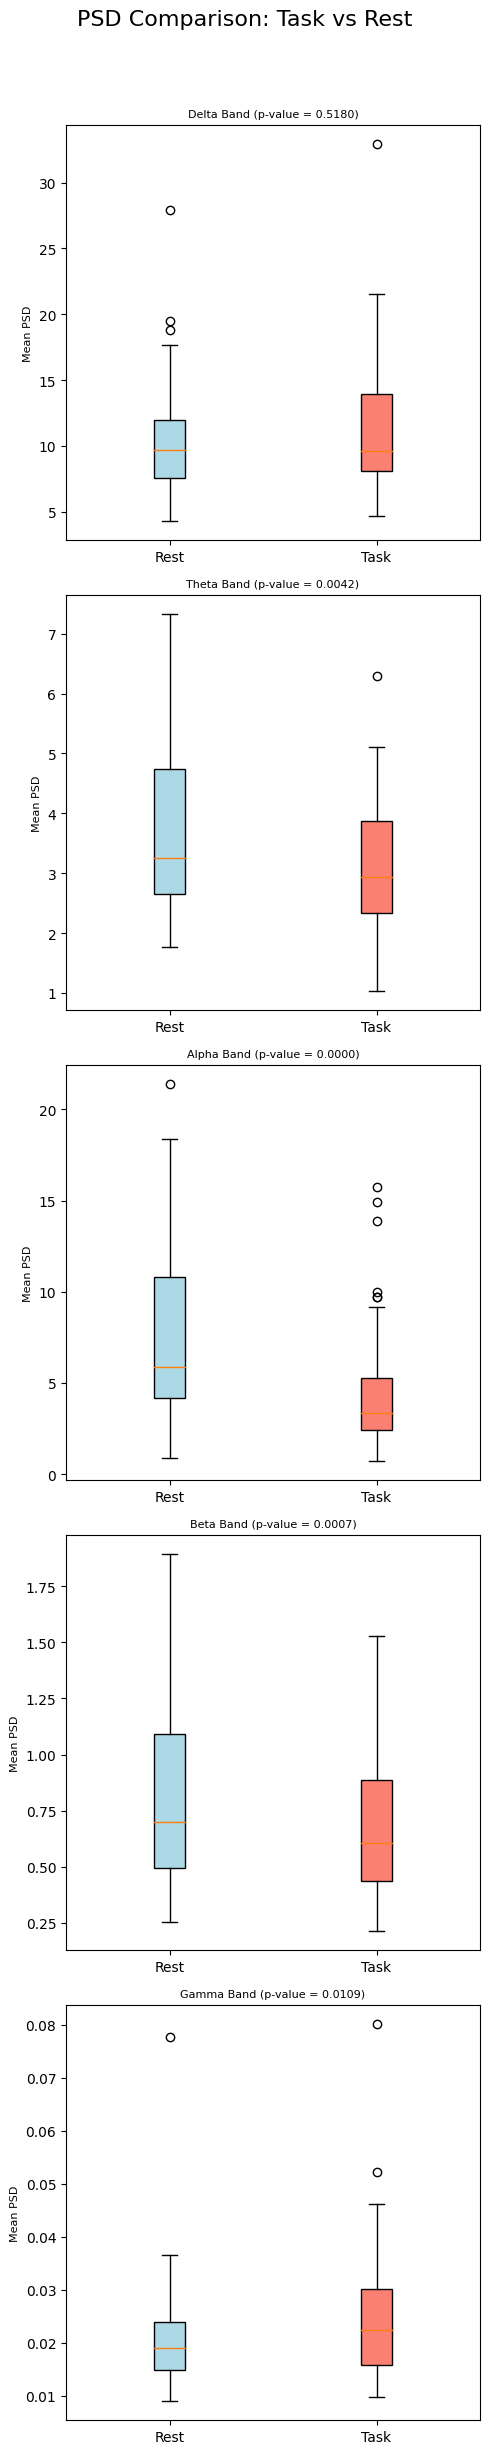

Average differences between Task and Rest states:
Average Delta difference (Task - Rest): 0.5413
Average Theta difference (Task - Rest): -0.5701
Average Alpha difference (Task - Rest): -2.6996
Average Beta difference (Task - Rest): -0.1287
Average Gamma difference (Task - Rest): 0.0041


In [11]:
fig, axs = plt.subplots(len(frequency_bands), 1, figsize=(5, 5 * len(frequency_bands)))
fig.suptitle('PSD Comparison: Task vs Rest', fontsize=16)

# Looping through each frequency band to perform paired t-tests and plotting
for i, band in enumerate(frequency_bands.keys()):
    rest_data = results_df[f'{band} rest Mean PSD']
    task_data = results_df[f'{band} task Mean PSD']

    # Performing a paired t-test between 'task' and 'rest' states
    t_stat, p_value = stats.ttest_rel(task_data, rest_data)

    # Creating boxplots for 'rest' and 'task' data
    bp = axs[i].boxplot([rest_data, task_data], labels=['Rest', 'Task'], patch_artist=True)

    # Coloring the boxplots
    colors = ['lightblue', 'salmon']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Setting the title of each subplot including the p-value from the t-test
    axs[i].set_title(f'{band} Band (p-value = {p_value:.4f})', fontsize=8)
    axs[i].set_ylabel('Mean PSD', fontsize=8)

# Adjusting the layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculating and printing the average differences for each band
print("Average differences between Task and Rest states:")
for band in frequency_bands.keys():
    avg_diff = summary_df[f'{band} Mean Difference'].mean()
    print(f"Average {band} difference (Task - Rest): {avg_diff:.4f}")

# Deep Learning Classification

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Lambda, Layer, Add, Multiply
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, SeparableConv2D, BatchNormalization, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [13]:
# Label Encoding subject names to integers
label_encoder = LabelEncoder()
subject_encoded = label_encoder.fit_transform(summary_df['Subject'])

summary_df['Subject'] = subject_encoded

# Dropping the label column
X = summary_df.drop(columns=['Count quality'])
y = summary_df['Count quality']  # Target label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting DataFrame to NumPy array before reshaping
X_train = X_train.values.reshape((X_train.shape[0], 1, 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, 1, X_test.shape[1]))

## EEGNET

In [14]:
def EEGNet(nb_classes, Samples, dropoutRate=0.5, F1=8, D=2, F2=16, kernLength=1):
    input1 = Input(shape=(1, 1, Samples))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((1, 1), use_bias=False, depth_multiplier=D)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = Dropout(dropoutRate)(block1)  # Removed pooling

    # Second block
    block2 = SeparableConv2D(F2, (1, kernLength), padding='same', use_bias=False)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = Dropout(dropoutRate)(block2)  # Removed pooling

    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

# Building the model
model = EEGNet(nb_classes=2, Samples=X_train.shape[3])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 6)]         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 8)           48        
                                                                 
 batch_normalization (Batch  (None, 1, 1, 8)           32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 1, 16)          16        
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 16)          64        
 chNormalization)                                                
                                                             

In [15]:
# Predicting the classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converting probabilities to class labels

y_test_classes = y_test

# Calculating metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 0s 314ms/step
Accuracy: 0.75
Precision: 0.5625
Recall: 0.75
F1 Score: 0.6428571428571428


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## VAE

In [16]:
# Reshaping
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
# Defining size of the latent space
latent_dim = 2

# Input layer
inputs = Input(shape=(X_train.shape[1],), name='encoder_input')
x = Dense(64, activation='relu')(inputs)

# Latent space definition
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Using reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Defining the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 6)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 64)                   448       ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    130       ['dense_1[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 2)                    130       ['dense_1[0][0]']             
                                                                                            

In [19]:
# Defining decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(64, activation='relu')(latent_inputs)
outputs = Dense(X_train.shape[-1], activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 582 (2.27 KB)
Trainable params: 582 (2.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Linking the encoder and decoder to form the full VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Defining the VAE loss as a combination of reconstruction and KL divergence
reconstruction_loss = K.mean(K.square(inputs - outputs))
reconstruction_loss *= X_train.shape[-1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [21]:
vae.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 414.9756 - val_loss: 635.7734
Epoch 2/50
1/1 [==============================] - 0s 39ms/step - loss: 413.1096 - val_loss: 633.5425
Epoch 3/50
1/1 [==============================] - 0s 39ms/step - loss: 411.5589 - val_loss: 631.3062
Epoch 4/50
1/1 [==============================] - 0s 39ms/step - loss: 410.1626 - val_loss: 628.9037
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 408.5244 - val_loss: 626.9740
Epoch 6/50
1/1 [==============================] - 0s 38ms/step - loss: 407.1450 - val_loss: 625.0991
Epoch 7/50
1/1 [==============================] - 0s 38ms/step - loss: 405.7984 - val_loss: 622.4799
Epoch 8/50
1/1 [==============================] - 0s 36ms/step - loss: 404.5349 - val_loss: 620.3752
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 403.0451 - val_loss: 618.8127
Epoch 10/50
1/1 [==============================] - 0s 36ms/step - loss: 402.1514 - val_loss: 

In [22]:
# Assuming the encoder model outputs the mean and log variance, we can take the mean as the latent representation
z_mean, _, _ = encoder.predict(X_train)

1/1 [==============================] - 0s 131ms/step


In [23]:
classifier = LogisticRegression()
classifier.fit(z_mean, y_train)  # Using latent space features from the training data

# Predicting labels for the test set
y_pred = classifier.predict(encoder.predict(X_test)[0])

1/1 [==============================] - 0s 31ms/step


In [24]:
# Calculating the perfomance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' average for multiclass classification
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.75
Precision: 0.375
Recall: 0.5
F1 Score: 0.42857142857142855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
